In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_simulation import multikron
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size":12,
    "font.serif": ["Computer Modern Roman"],
})

In [150]:
I = np.eye(2)
X = np.array([[0,1], [1,0]])
Y = np.array([[0,-1j], [1j,0]])
Z = np.diag([1,-1])
Paulis = [I, X, Y, Z]

ket_0 = np.array([[1], [0]])
ket_1 = np.array([[0], [1]])
ket_plus = np.array([[1], [1]]) / np.sqrt(2)
ket_minus = np.array([[1], [-1]]) / np.sqrt(2)
ket_iplus = np.array([[1], [1j]]) / np.sqrt(2)
ket_iminus = np.array([[1], [-1j]]) / np.sqrt(2)

pauli_eigenbases = [ket_0, ket_1, ket_plus, ket_minus, ket_iplus, ket_iminus]

H = np.array([[1,1], [1,-1]]) / np.sqrt(2)
S = np.diag([1, 1j])

M_ensemble_single_q = [I, H, H@S.conj().T]

# Sum over all single-qubit Pauli eigenprojectors, each tensored with itself
$$ \sum_{\substack{U\in\{\mathbb I, H, HS^\dagger \\ b\in\{0,1\}\}}} \left(U^\dagger |b\rangle\!\langle b|U\right)^{\otimes n} = |0\rangle\!\langle 0|^{\otimes 2} + |1\rangle\!\langle 1|^{\otimes 2} + |+\rangle\!\langle +|^{\otimes 2} + |-\rangle\!\langle -|^{\otimes 2} + |\mathrm i_+\rangle\!\langle \mathrm i_+|^{\otimes 2} + |\mathrm i_-\rangle\!\langle \mathrm i_-|^{\otimes 2}$$

In [3]:
result = 0 + 0j
for eigvects in pauli_eigenbases:
    outer_prod = np.outer(eigvects, eigvects.conj())
    result += np.kron(outer_prod, outer_prod)
result


print(result.real)

[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]


# Single qubit

## Snapshot
Given data tuple (the shadow) $(U,b)$, the shadow snapshot reads as $ \hat\rho = 3U^\dagger|b\rangle\!\langle b|U - \mathbb I$.

In [176]:
def build_single_q_snapshot(U, b):
    proj = np.eye(2)[b] 
    return 3 * U.conj().T @ np.outer(proj, proj.conj()) @ U - I

### Examples

In [177]:
U = M_ensemble_single_q[0]
b = 0
snapshot = build_single_q_snapshot(U, b)
print(f'for U={U} and b={b} the matrix representation of the snapshot looks like:')
print(snapshot)

for U=[[1. 0.]
 [0. 1.]] and b=0 the matrix representation of the snapshot looks like:
[[ 2.  0.]
 [ 0. -1.]]


## Data Simulation (decide on quantum state)
Draw the measurement unitary at random and then sample an outcome according to the probability distribution of the given quantum state.

In [178]:
rng = np.random.default_rng()

psi_singleq = ket_1
rho_single_q = np.outer(psi_singleq, psi_singleq.conj())

In [179]:
one_random_basis = rng.integers(0, 3)
print('index of measurement unitary:', one_random_basis)
U = M_ensemble_single_q[one_random_basis]
rho_rotated = U @ rho_single_q @ U.conj().T
probs = np.diag(rho_rotated).real
print('probabilities to measure computational basis states:', probs)
single_outcome = rng.binomial(1, probs[1])
print('Simulated single outcome:', single_outcome)

index of measurement unitary: 1
probabilities to measure computational basis states: [0.5 0.5]
Simulated single outcome: 1


### Simulate lots of snapshots

In [180]:
N = 10000
collection_shadows = np.empty((N, 2), dtype=int)
for countN in range(N):
    U_index = rng.integers(0, 3)
    U = M_ensemble_single_q[U_index]
    rho_rotated = U @ rho_single_q @ U.conj().T
    probs = np.diag(rho_rotated).real
    probs = probs / np.sum(probs)
    single_shot = rng.binomial(1, probs[1])
    collection_shadows[countN] = [U_index, single_shot]
# print(collection_shadows)

## Reconstruct state from shadows 
-> possible, but not recommended ;)

In [181]:
rho_rec = 0 + 0j
for shadow in collection_shadows:
    U_index, b = shadow
    U = M_ensemble_single_q[U_index]
    snapshot = build_single_q_snapshot(U, b)
    rho_rec += snapshot
rho_rec /= len(collection_shadows)
print(f'Reconstructed state from {N} shots:')
print(rho_rec)
print('target state:')
print(rho_single_q)

Reconstructed state from 10000 shots:
[[0.005 +0.j     0.0021-0.0033j]
 [0.0021+0.0033j 0.995 +0.j    ]]
target state:
[[0 0]
 [0 1]]


## Estimate fidelity
pure state fidelity  = $\mathrm{tr}(\bar\rho\rho)$ with $\bar rho$ the multi-shot estimator

In [182]:
all_singleq_fidelities_ss = np.empty(N)

for countN, shadow in enumerate(collection_shadows):
    U_index, b = shadow
    U = M_ensemble_single_q[U_index]
    snapshot = build_single_q_snapshot(U, b)
    fidelity_ss = np.trace(snapshot @ rho_single_q).real
    all_singleq_fidelities_ss[countN] = fidelity_ss
estimate_fidelity = np.average(all_singleq_fidelities_ss)
print(f'all {N} single shot estimators:')
print(all_singleq_fidelities_ss)
print(f'Multi-shot estimator with {N} many shot:')
print(estimate_fidelity)
all_multi_shot_estims = np.cumsum(all_singleq_fidelities_ss) / np.arange(1, N+1)
print(all_multi_shot_estims)


all 10000 single shot estimators:
[0.5 0.5 0.5 ... 0.5 0.5 0.5]
Multi-shot estimator with 10000 many shot:
0.995
[0.5        0.5        0.5        ... 0.99509902 0.9950495  0.995     ]


### Plot 

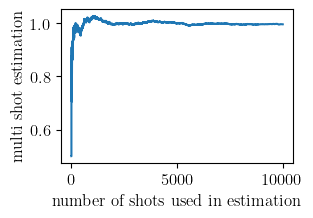

In [183]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(all_multi_shot_estims)
ax.set_ylabel('multi shot estimation')
ax.set_xlabel('number of shots used in estimation')
plt.show()

## Estimate Expectation Values of Observables

### Define single shot estimator for Pauli expectation values

Single shot estimator for Pauli X observable: $\mathrm{tr}(\hat \rho X) = 3(-1)^b\delta_{U,H}$

Single shot estimator for Pauli Y observable: $\mathrm{tr}(\hat \rho Y) = 3(-1)^b\delta_{U,HS^\dagger}$

Single shot estimator for Pauli Z observable: $\mathrm{tr}(\hat \rho Z) = 3(-1)^b\delta_{U,\mathbb I}$

In [184]:
def calc_X_ss(U_index, b):
    if U_index == 1:
        return 3 * (-1) ** b
    else:
        return 0

def calc_Y_ss(U_index, b):
    if U_index == 2:
        return 3 * (-1) ** b
    else:
        return 0

def calc_Z_ss(U_index, b):
    if U_index == 0:
        return 3 * (-1) ** b
    else:
        return 0

### Single shadow Example with Z-observable

In [210]:
shadow_example = collection_shadows[3]
print('one qubit shadow')
print(shadow_example)
U_index,b = shadow_example
U = M_ensemble_single_q[U_index]
snapshot = build_single_q_snapshot(U, b)
print('single shot estimator with snapshot of Z observable')
print(np.trace(snapshot @ Z))
print('simplified single shot estimator of Z observable')
print(calc_Z_ss(U_index, b))

one qubit shadow
[0 1]
single shot estimator with snapshot of Z observable
-3.0
simplified single shot estimator of Z observable
-3


### Estimate Z-observable

In [211]:
all_my_Z_ss = np.empty(N)

for count, shadow in enumerate(collection_shadows):
    all_my_Z_ss[count] = calc_Z_ss(*shadow)

### Plot

[0. 0. 0. ... 0. 0. 0.]
-0.99
[ 0.          0.          0.         ... -0.99019804 -0.99009901
 -0.99      ]


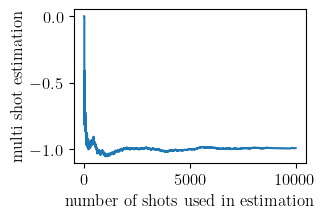

In [ ]:

multi_shot_estimate_Z = np.average(all_my_Z_ss)
cummulative_estims_of_Z = np.cumsum(all_my_Z_ss) / np.arange(1, N+1) 
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(cummulative_estims_of_Z)
ax.set_ylabel('multi shot estimation')
ax.set_xlabel('number of shots used in estimation')
plt.show()

## Estimate X, Y, Z observables at one

### True values

In [ ]:
expected_trOrs = np.array([np.trace(X @ rho_single_q), np.trace(Y @ rho_single_q), np.trace(Z @ rho_single_q)]).real
labels = [r'$\mathrm{tr}(\rho X)$',r'$\mathrm{tr}(\rho Y)$',r'$\mathrm{tr}(\rho Z)$'] 

## Estimation

In [212]:
all_my_observable_ss = np.empty((3, N))

for count, shadow in enumerate(collection_shadows):
    U_index, b = shadow
    all_my_observable_ss[:,count] = [calc_X_ss(U_index, b), calc_Y_ss(U_index, b), calc_Z_ss(U_index, b)]
cummulative_estims = np.cumsum(all_my_observable_ss, axis=1) / np.arange(1, N+1).reshape(1, -1)

### Plot estimates and true values

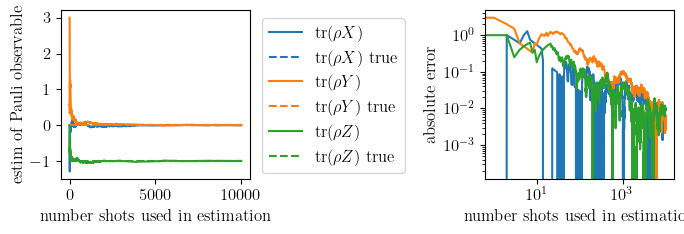

In [233]:

fig, (ax, ax1) = plt.subplots(1,2, figsize=(7,2.5))
for count, o_estim in enumerate(cummulative_estims):
    line, = ax.plot(o_estim, label=labels[count])  
    color = line.get_color()                       
    
    expected_value = expected_trOrs[count]
    ax.plot([0, N],
             [expected_value, expected_value],
             '--',
             color=color,                          
             label=labels[count] + ' true')
    ax1.plot(np.abs(o_estim - expected_value), color=color)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylabel('absolute error')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.set_xlabel('number shots used in estimation')
ax1.set_xlabel('number shots used in estimation')
ax.set_ylabel('estim of Pauli observable')
plt.tight_layout()
plt.show()

# Multiple Qubits

## Snapshot
Given a data tuple (i.e. a shadow) of unitaries per qubit and outcome per qubit as $((U_1,U_2,\ldots,U_n), (b_1,b_2,\ldots,b_n))$, the snapshot reads:

$\hat\rho = \textstyle{\bigotimes_{j=1}^n}\left(3U_j^\dagger|b_j\rangle\!\langle b_j|U_j - \mathbb I\right)$

In [189]:
def build_multiq_snapshot(Us, bs):
    all_single_q_snapshots = []
    for U, b in zip(Us, bs):
        single_q_snapshot = build_single_q_snapshot(U, b)
        all_single_q_snapshots.append(single_q_snapshot)
    snapshot_multi_q = multikron(*all_single_q_snapshots)
    return snapshot_multi_q


### Example

In [190]:
single_shadow = [[I, H, I , H@S.conj().T],[0,1,0,0]]
Us, bs = single_shadow
# print(build_multiq_snapshot(Us, bs))

## Simulate lots of snapshots

In [191]:
from data_simulation import data_simulation_multi_q
bell_state = (np.kron(ket_0, ket_0) + np.kron(ket_1, ket_1))/np.sqrt(2)

psi_multiq = multikron(bell_state, bell_state)
rho_multiq = np.outer(psi_multiq, psi_multiq.conj())
nqubits = int(np.log2(len(rho_multiq)))

N = 10000
collection_shadows_multiq = data_simulation_multi_q(rho_multiq, M_ensemble_single_q, N)


## Reconstruct state from shadows

In [192]:
rho_rec_multiq = 0 + 0j
for shadow in collection_shadows_multiq:
    Us_indices, bs = shadow
    Us = np.take(M_ensemble_single_q, Us_indices, axis=0)
    snapshot = build_multiq_snapshot(Us, bs)
    rho_rec_multiq += snapshot
rho_rec_multiq /= len(collection_shadows)

### Plot

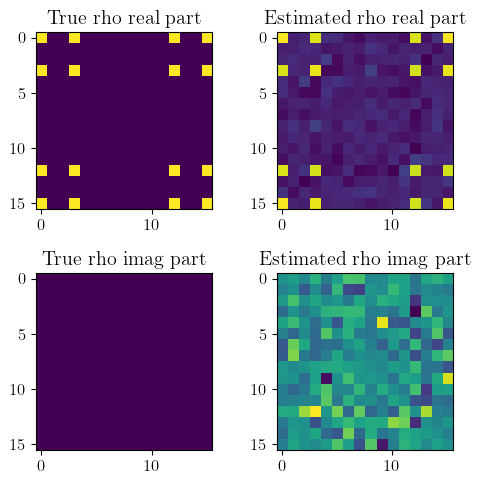

In [193]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(5,5))
ax1.imshow(rho_multiq.real)
ax1.set_title('True rho real part')
ax3.imshow(rho_multiq.imag)
ax3.set_title('True rho imag part')
ax2.imshow(rho_rec_multiq.real)
ax2.set_title('Estimated rho real part')
ax4.imshow(rho_rec_multiq.imag)
ax4.set_title('Estimated rho imag part')
plt.tight_layout()
plt.show()

## Reconstruct Expectation Values from Observables

### Define single shot estimators without reconstruction snapshots
Single shot estimator for Pauli X observable: $\mathrm{tr}(\hat \rho X\otimes X) = 9(-1)^{b_1+b_2}\delta_{(U_1,H_2),(H,H)}$

Single shot estimator for Pauli Y observable: $\mathrm{tr}(\hat \rho Y\otimes Y) = 9(-1)^{b_1+b_2}\delta_{(U_1,H_2),(HS^\dagger,HS^\dagger)}$

Single shot estimator for Pauli Z observable: $\mathrm{tr}(\hat \rho Z\otimes Z) = 9(-1)^{b_1+b_2}\delta_{(U_1,H_2),(\mathbb I,\mathbb I)}$

In [194]:
def calc_XX_corr_ss(U_indices, bs):
    if np.array_equal(U_indices, [1, 1]):
        return 9 * (-1) ** (bs[0] + bs[1])
    else:
        return 0


def calc_YY_corr_ss(U_indices, bs):
    if np.array_equal(U_indices, [2, 2]):
        return 9 * (-1) ** (bs[0] + bs[1])
    else:
        return 0

def calc_ZZ_corr_ss(U_indices, bs):
    if np.array_equal(U_indices, [0, 0]):
        return 9 * (-1) ** (bs[0] + bs[1])
    else:
        return 0



## All 2-body subsystems of $n$ qubits

In [195]:
from itertools import combinations
subsystems = np.array(list(combinations(range(nqubits), r=2)))

## Estimate 2-body $ZZ$-correlations for $n$-qubit state

### True values

In [196]:
example_subsystem = subsystems[-1]
list_of_paulis =[Z if i in example_subsystem else I for i in range(nqubits)]
matrix = multikron(*list_of_paulis)

In [197]:
all_true_ZZ_corr = np.empty(len(subsystems))
for counts, subsys in enumerate(subsystems):
    list_of_paulis =[Z if i in subsys else I for i in range(nqubits)]
    matrix = multikron(*list_of_paulis)
    all_true_ZZ_corr[counts] = np.round(np.trace(matrix @ rho_multiq).real, 10)

### Example with one shadow

In [198]:
shadow_example = collection_shadows_multiq[2]
print('one multi qubit shadow')
print(shadow_example)
print('marginalized shadow')
marginalized_shadow = shadow_example[:,np.array([1,3])]
print(marginalized_shadow)
Us_marg = np.take(M_ensemble_single_q,marginalized_shadow[0], axis=0)
bs_marg = marginalized_shadow[1]
snapshot_marg = build_multiq_snapshot(Us_marg, bs_marg)
print('With snapshot tr(hat rho@Z)')
print(np.trace(snapshot_marg @ np.kron(Z,Z)))
print('Without reconstruction snapshot')
print(calc_ZZ_corr_ss(marginalized_shadow[0], marginalized_shadow[1]))

one multi qubit shadow
[[2 2 2 2]
 [1 0 1 0]]
marginalized shadow
[[2 2]
 [0 0]]
With snapshot tr(hat rho@Z)
0j
Without reconstruction snapshot
0


### Estimation 

In [199]:
all_my_Z_corrs_ss = np.empty((len(subsystems), N))
for countN, shadow in enumerate(collection_shadows_multiq):
    U_indices, bs = shadow
    for countS, subsys in enumerate(subsystems):
        U_indices_marg = U_indices[subsys]
        bs_marg = bs[subsys]
        all_my_Z_corrs_ss[countS, countN] = calc_ZZ_corr_ss(U_indices_marg, bs_marg)
all_my_Z_corrs_estims = np.cumsum(all_my_Z_corrs_ss, axis=1) / np.arange(1, N+1).reshape(1,-1)

### Plot Estimation

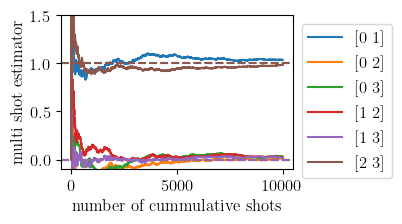

In [200]:
fig, ax = plt.subplots(figsize=(3,2))
for countS, data in enumerate(all_my_Z_corrs_estims):
    line, = ax.plot(data, label=str(subsystems[countS]))
    true_exp_value = all_true_ZZ_corr[countS]
    ax.axhline(true_exp_value, linestyle='--', color=line.get_color())
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('number of cummulative shots')
ax.set_ylabel('multi shot estimator')
ax.set_ylim(-0.1,1.5)
plt.show()

## Estimate all XX, YY, and ZZ correlations all at once


### True values

In [201]:
all_my_corr_trues = np.empty((3, len(subsystems)), dtype=float)
for count_s, subsys in enumerate(subsystems):
    gates_X = [X if i in subsys else I for i in range(nqubits)]
    expXX = np.trace(multikron(*gates_X) @ rho_multiq).real
    gates_Y = [Y if i in subsys else I for i in range(nqubits)]
    expYY = np.trace(multikron(*gates_Y) @ rho_multiq).real
    gates_Z = [Z if i in subsys else I for i in range(nqubits)]
    expZZ = np.trace(multikron(*gates_Z) @ rho_multiq).real
    all_my_corr_trues[:, count_s] = [expXX, expYY, expZZ]


### Estimation

In [202]:
all_my_corr_ss = np.empty((3, len(subsystems), N))
for countN, shadow in enumerate(collection_shadows_multiq):
    settings, outcomes = shadow
    for count_s, s in enumerate(subsystems):
        marginalized_settings, marginalized_outcomes = settings[s], outcomes[s]
        all_my_corr_ss[:,count_s, countN] = [
            calc_XX_corr_ss(marginalized_settings, marginalized_outcomes),
            calc_YY_corr_ss(marginalized_settings, marginalized_outcomes),
            calc_ZZ_corr_ss(marginalized_settings, marginalized_outcomes),
        ]
cummulative_estims = np.cumsum(all_my_corr_ss, axis=2) / np.arange(1, N+1).reshape(1,1, -1)

### Plot Estimations and True Values

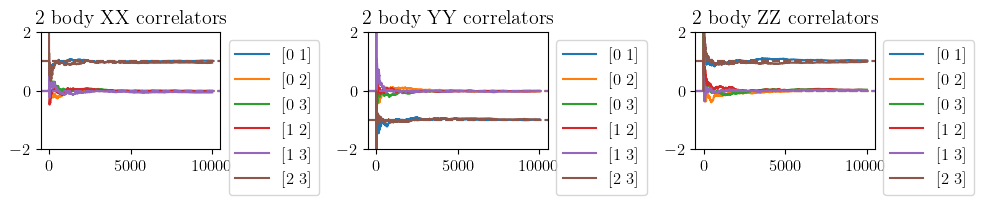

In [203]:
fig, axes = plt.subplots(1,3, figsize=(10,2))
ax0, ax1, ax2 = axes

for count_s, data in enumerate(cummulative_estims[0]):
    line, = ax0.plot(data, label=str(subsystems[count_s]))
    ax0.axhline(all_my_corr_trues[0, count_s], color=line.get_color(), linestyle='--')
ax0.set_title('2 body XX correlators')

for count_s, data in enumerate(cummulative_estims[1]):
    line, = ax1.plot(data, label=str(subsystems[count_s]))
    ax1.axhline(all_my_corr_trues[1, count_s], color=line.get_color(), linestyle='--')
ax1.set_title('2 body YY correlators')

for count_s, data in enumerate(cummulative_estims[2]):
    line, = ax2.plot(data, label=str(subsystems[count_s]))
    ax2.axhline(all_my_corr_trues[2, count_s], color=line.get_color(), linestyle='--')
ax2.set_title('2 body ZZ correlators')

for ax in axes:
    ax.set_ylim(-2,2)
    ax.legend(bbox_to_anchor=(1,1))
plt.tight_layout()